In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import matplotlib.pyplot as plt

In [2]:
# seed for reproducibility
my_seed = 1980

In [3]:
# read data
my_path = '../'

train = pd.read_csv(my_path + 'data/c2_e6_2_train.csv')
val = pd.read_csv(my_path + 'data/c2_e6_1_validation.csv')
test = pd.read_csv(my_path + 'data/c2_e6_1_test.csv')

In [4]:
# Testing External Information - Direct Approach

print(classification_report(test['label'], test['base_guess']))
print('Confusion Matrix:\n\n ' + str(confusion_matrix(test['label'], test['base_guess'])))

             precision    recall  f1-score   support

          0       0.96      0.92      0.94     11897
          1       0.11      0.20      0.14       580

avg / total       0.92      0.89      0.90     12477

Confusion Matrix:

 [[10961   936]
 [  465   115]]


In [5]:
fpr, tpr, thresholds = roc_curve(test['label'], test['base_guess'])

In [6]:
my_auc = auc(fpr, tpr)
my_auc

0.5598002828878912

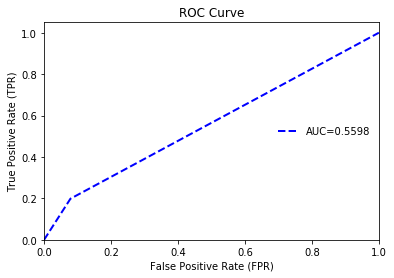

In [8]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='blue',
         lw=lw, label='AUC=%0.4f' % my_auc, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="right",  frameon=False)
plt.show()

In [46]:
# Testing External Information - Searching for a Threshold

step = 0.0536503
minimum = np.min(train['v50'])
maximum = np.max(train['v50']) + step

cv_list = [0, 1, 2, 3, 4]
cv_index = np.random.choice(5, len(train), replace=True)
cv_index.sort()

ext = train[['v50', 'label']]
ext.loc[:, 'cv'] = cv_index

best_f1_mean = 0
best_threshold = 0

for threshold in np.arange(minimum, maximum, step):
    f1_list = []
    
    for cv in cv_list:
        cv_test = ext.loc[ext['cv'] == cv]
        cv_test.is_copy = False
        
        cv_test['guess'] = 0
        cv_test.loc[cv_test['v50'] >= threshold, 'guess'] = 1

        cm = confusion_matrix(cv_test['label'], cv_test['guess'])
        try:
            f1 = 2 * cm[1][1] / float(2 * cm[1][1] + cm[0][1] + cm[1][0])
        except IndexError:
            f1 = 0
        f1_list.append(f1)
        
    f1_mean = np.mean(f1_list)
    
    if f1_mean > best_f1_mean:
        best_threshold = threshold
        best_f1_mean = f1_mean

print("Best Threshold: " + str(best_threshold))
print("F1-Measure:" + str(best_f1_mean))

Best Threshold: 0.3219018
F1-Measure:0.5688362619421152


In [47]:
# Test Threshold

ext = test[['v50', 'label']]
ext.loc[:, 'guess'] = 0
ext.loc[ext['v50'] >= best_threshold, 'guess'] = 1

print(classification_report(ext['label'], ext['guess']))

cm = confusion_matrix(ext['label'], ext['guess'])
print('Confusion Matrix:\n\n ' + str(cm))


             precision    recall  f1-score   support

          0       0.99      0.39      0.56     11897
          1       0.07      0.92      0.13       580

avg / total       0.95      0.41      0.54     12477

Confusion Matrix:

 [[4604 7293]
 [  49  531]]


In [48]:
fpr, tpr, thresholds = roc_curve(ext['label'], ext['guess'])

In [49]:
my_auc = auc(fpr, tpr)
my_auc

0.6512527788807958

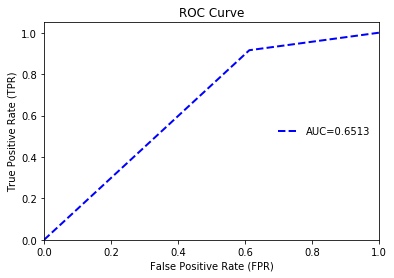

In [50]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='blue',
         lw=lw, label='AUC=%0.4f' % my_auc, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="right",  frameon=False)
plt.show()